## Confronto dei modelli allenati 

Al fine di confrontare in modo sistematico le prestazioni dei modelli considerati, viene costruita una tabella riassuntiva che riporta, per ciascun task di classificazione (categoria e priorità), le principali metriche di valutazione.

In particolare, per ogni combinazione di task e modello vengono riportate l’accuracy e la F1-score macro.

Questo confronto consente di valutare se eventuali differenze nelle prestazioni siano attribuibili alla scelta del modello di classificazione oppure se le performance risultino principalmente vincolate dalle caratteristiche intrinseche del dataset sintetico utilizzato.



In [1]:
import importlib
import sys
sys.path.append('..')

from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"

import src.config.settings as settings
importlib.reload(settings)

USE_TITLE = settings.USE_TITLE
TOTAL_TICKETS = settings.TOTAL_TICKETS
NOISE_CONFIG = settings.NOISE_CONFIG

import json
import pandas as pd
from datetime import datetime
from pathlib import Path

# Metadati dell'esperimento
RUN_TIMESTAMP = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

with open(DATA_DIR / "results_baseline" / "logistic_metrics.json", "r") as f:
    lr = json.load(f)

with open(DATA_DIR / "results_baseline" / "svm_metrics.json", "r") as f:
    svm = json.load(f)

with open(DATA_DIR / "results_baseline" / "nb_metrics.json", "r") as f:
    nb = json.load(f)

df = pd.DataFrame([
    ["categoria", "LogisticRegression", lr["categoria_accuracy"], lr["categoria_f1_macro"]],
    ["categoria", "LinearSVM",         svm["categoria_accuracy"], svm["categoria_f1_macro"]],
    ["categoria", "Naive Bayes", nb["categoria_accuracy"], nb["categoria_f1_macro"]],
    ["priorità",  "LogisticRegression", lr["priorita_accuracy"], lr["priorita_f1_macro"]],
    ["priorità",  "LinearSVM",          svm["priorita_accuracy"], svm["priorita_f1_macro"]],
    ["priorità",  "Naive Bayes",          nb["priorita_accuracy"], nb["priorita_f1_macro"]],
], columns=["task", "model", "accuracy", "f1_macro"])

# Aggiunta metadati di run
df["run_timestamp"] = RUN_TIMESTAMP
df["use_title"] = USE_TITLE
df["total_ticket"] = TOTAL_TICKETS
df["noise_config"] = json.dumps(NOISE_CONFIG)

# Persistenza incrementale su CSV
output_path = Path(DATA_DIR / "results_baseline" / "experiments_log.csv")

df.to_csv(
    output_path,
    mode="a",
    header=not output_path.exists(),
    index=False,
    sep=";"
)

df


,task,model,accuracy,f1_macro,run_timestamp,use_title,total_ticket,noise_config
0,categoria,LogisticRegression,0.968750,0.970582,2026-01-05 22:50:31,False,480,"{""typo_probability"": 0.05, ""abbreviation_proba..."
1,categoria,LinearSVM,0.989583,0.990321,2026-01-05 22:50:31,False,480,"{""typo_probability"": 0.05, ""abbreviation_proba..."
2,categoria,Naive Bayes,0.906250,0.904184,2026-01-05 22:50:31,False,480,"{""typo_probability"": 0.05, ""abbreviation_proba..."
3,priorità,LogisticRegression,0.812500,0.817894,2026-01-05 22:50:31,False,480,"{""typo_probability"": 0.05, ""abbreviation_proba..."
4,priorità,LinearSVM,0.885417,0.889497,2026-01-05 22:50:31,False,480,"{""typo_probability"": 0.05, ""abbreviation_proba..."
5,priorità,Naive Bayes,0.822917,0.826703,2026-01-05 22:50:31,False,480,"{""typo_probability"": 0.05, ""abbreviation_proba..."


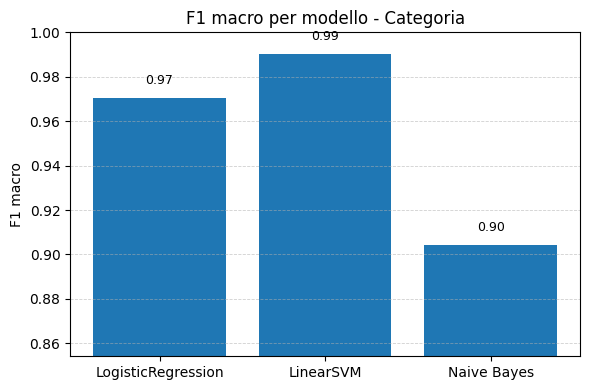

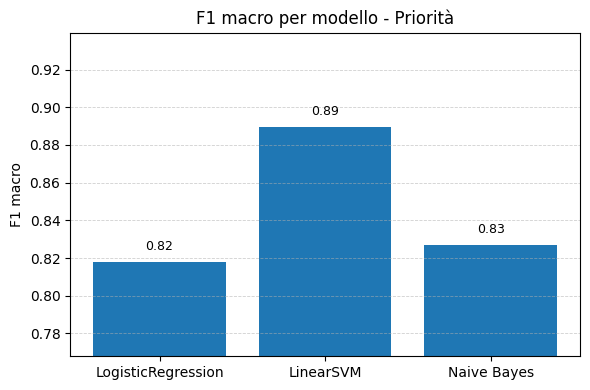

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Ordine coerente dei modelli 
model_order = ["LogisticRegression", "LinearSVM", "Naive Bayes"]

def plot_task_bars(df, task_name, title_suffix):
    subset = df[df["task"] == task_name].copy()

    # Riordino per rendere il grafico stabile e leggibile
    subset["model"] = pd.Categorical(subset["model"], categories=model_order, ordered=True)
    subset = subset.sort_values("model")

    x = np.arange(len(subset["model"]))
    y = subset["f1_macro"].values

    plt.figure(figsize=(6,4))
    bars = plt.bar(x, y)

    plt.xticks(x, subset["model"])
    plt.ylabel("F1 macro")
    plt.title(f"F1 macro per modello - {title_suffix}")

    # Limiti Y "tight" per migliorare la leggibilità (con un margine)
    y_min = max(0, y.min() - 0.05)
    y_max = min(1.0, y.max() + 0.05)
    plt.ylim(y_min, y_max)

    # Griglia orizzontale
    plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)

    # Etichette valori sopra le barre
    for rect, val in zip(bars, y):
        plt.text(
            rect.get_x() + rect.get_width()/2,
            rect.get_height() + 0.005,
            f"{val:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

# Due grafici separati
plot_task_bars(df, "categoria", "Categoria")
plot_task_bars(df, "priorità", "Priorità")
